In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# 1. 状态空间

In [2]:
states = ["outing", "shopping", "home"]

In [3]:
hidden_states = ["rainy", "sunny"]
p0 = [0.6, 0.4]

In [4]:
state_space = pd.Series(p0, index=hidden_states, name="hidden_states")

In [5]:
state_space

rainy    0.6
sunny    0.4
Name: hidden_states, dtype: float64

In [6]:
a_df = pd.DataFrame(columns=hidden_states, index=hidden_states)
a_df.loc[hidden_states[0]] = [0.7, 0.3]
a_df.loc[hidden_states[1]] = [0.4, 0.6]

In [7]:
a = a_df.values

In [8]:
a_df

,rainy,sunny
rainy,0.7,0.3
sunny,0.4,0.6


In [9]:
b_df = pd.DataFrame(columns=states, index=hidden_states)
b_df.loc[hidden_states[0]] = [0.1, 0.4, 0.5]
b_df.loc[hidden_states[1]] = [0.6, 0.3, 0.1]

In [10]:
b = b_df.values

In [11]:
b_df

,outing,shopping,home
rainy,0.1,0.4,0.5
sunny,0.6,0.3,0.1


# 2. 图模型

In [12]:
def get_markov_edges(H):
    edges = {}
    for col in H.columns:
        for idx in H.index:
            edges[(idx, col)] = H.loc[idx, col]
    
    return edges

In [13]:
hidden_edges = get_markov_edges(a_df)
emit_edges = get_markov_edges(b_df)

In [14]:
hidden_edges

{('rainy', 'rainy'): 0.7,
 ('sunny', 'rainy'): 0.4,
 ('rainy', 'sunny'): 0.3,
 ('sunny', 'sunny'): 0.6}

In [15]:
emit_edges

{('rainy', 'outing'): 0.1,
 ('sunny', 'outing'): 0.6,
 ('rainy', 'shopping'): 0.4,
 ('sunny', 'shopping'): 0.3,
 ('rainy', 'home'): 0.5,
 ('sunny', 'home'): 0.1}

In [16]:
G = nx.MultiDiGraph()

In [17]:
G.add_nodes_from(hidden_states)
G.nodes()

NodeView(('rainy', 'sunny'))

In [18]:
for k,v in hidden_edges.items():
    tmp_ori, tmp_dst = k[0], k[1]
    G.add_edge(tmp_ori, tmp_dst, weight=v, label=v)

In [19]:
for k,v in emit_edges.items():
    tmp_ori, tmp_dst = k[0], k[1]
    G.add_edge(tmp_ori, tmp_dst, weight=v, label=v)

In [20]:
print(G.edges(data=True))

[('rainy', 'rainy', {'weight': 0.7, 'label': 0.7}), ('rainy', 'sunny', {'weight': 0.3, 'label': 0.3}), ('rainy', 'outing', {'weight': 0.1, 'label': 0.1}), ('rainy', 'shopping', {'weight': 0.4, 'label': 0.4}), ('rainy', 'home', {'weight': 0.5, 'label': 0.5}), ('sunny', 'rainy', {'weight': 0.4, 'label': 0.4}), ('sunny', 'sunny', {'weight': 0.6, 'label': 0.6}), ('sunny', 'outing', {'weight': 0.6, 'label': 0.6}), ('sunny', 'shopping', {'weight': 0.3, 'label': 0.3}), ('sunny', 'home', {'weight': 0.1, 'label': 0.1})]


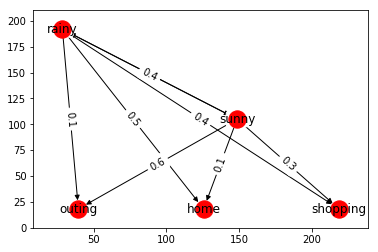

In [21]:
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_markov.dot')

# 3. Viterbi Algorithm

In [22]:
state_map = {0:"rainy", 1:"sunny"}
obs_map = {"outing":0, "shopping":1, "home":2}
obs = np.array([1,1,2,1,0,1,2,1,0,2,2,0,1,0,1])

In [23]:
inv_obs_map = dict((v,k) for k,v in obs_map.items())
obs_seq = [inv_obs_map[v] for v in list(obs)]

In [24]:
print(pd.DataFrame(np.column_stack([obs, obs_seq]),
                   columns=["Obs_code", "Obs_seq"]))

   Obs_code   Obs_seq
0         1  shopping
1         1  shopping
2         2      home
3         1  shopping
4         0    outing
5         1  shopping
6         2      home
7         1  shopping
8         0    outing
9         2      home
10        2      home
11        0    outing
12        1  shopping
13        0    outing
14        1  shopping


In [25]:
def viterbi(p0, a, b, obs):
    
    nStates = np.shape(b)[0]
    T = np.shape(obs)[0]
    
    path = np.zeros(T)
    delta = np.zeros((nStates, T))
    phi = np.zeros((nStates, T))
    
    delta[:,0] = p0 * b[:, obs[0]]
    phi[:,0] = 0
       
    print("\nStart Walk Forward\n")
    
    for t in range(1, T):
        for s in range(nStates):
            delta[s, t] = np.max(delta[:, t-1] * a[:, s]) * b[s, obs[t]]
            phi[s, t] = np.argmax(delta[:, t-1] * a[:, s])
            print("s={s} and t={t}: phi[{s}, {t}] = {phi}".format(s=s, t=t, phi=phi[s,t]))
            
    print("-"*50)
    print("\nStart Backtrace\n")
    
    path[T-1] = np.argmax(delta[:, T-1])
    
    for t in range(T-2, -1, -1):
        path[t] = phi[int(path[t+1]), t+1]
        print("path[{}] = {}".format(t, path[t]))
        
    return path, delta, phi

In [26]:
path, delta, phi = viterbi(p0, a, b, obs)

print("\nsingle best state path: \n", path)
print("delta:\n", delta)
print("phi:\n", phi)


Start Walk Forward

s=0 and t=1: phi[0, 1] = 0.0
s=1 and t=1: phi[1, 1] = 0.0
s=0 and t=2: phi[0, 2] = 0.0
s=1 and t=2: phi[1, 2] = 0.0
s=0 and t=3: phi[0, 3] = 0.0
s=1 and t=3: phi[1, 3] = 0.0
s=0 and t=4: phi[0, 4] = 0.0
s=1 and t=4: phi[1, 4] = 0.0
s=0 and t=5: phi[0, 5] = 1.0
s=1 and t=5: phi[1, 5] = 1.0
s=0 and t=6: phi[0, 6] = 0.0
s=1 and t=6: phi[1, 6] = 1.0
s=0 and t=7: phi[0, 7] = 0.0
s=1 and t=7: phi[1, 7] = 0.0
s=0 and t=8: phi[0, 8] = 0.0
s=1 and t=8: phi[1, 8] = 0.0
s=0 and t=9: phi[0, 9] = 1.0
s=1 and t=9: phi[1, 9] = 1.0
s=0 and t=10: phi[0, 10] = 0.0
s=1 and t=10: phi[1, 10] = 0.0
s=0 and t=11: phi[0, 11] = 0.0
s=1 and t=11: phi[1, 11] = 0.0
s=0 and t=12: phi[0, 12] = 1.0
s=1 and t=12: phi[1, 12] = 1.0
s=0 and t=13: phi[0, 13] = 0.0
s=1 and t=13: phi[1, 13] = 1.0
s=0 and t=14: phi[0, 14] = 1.0
s=1 and t=14: phi[1, 14] = 1.0
--------------------------------------------------

Start Backtrace

path[13] = 1.0
path[12] = 1.0
path[11] = 1.0
path[10] = 0.0
path[9] = 0.0
path

In [27]:
state_path = [state_map[v] for v in path]

In [28]:
pd.DataFrame({
    "Observation":obs_seq,
    "Best Path":state_path
})

,Observation,Best Path
0,shopping,rainy
1,shopping,rainy
2,home,rainy
3,shopping,rainy
4,outing,sunny
5,shopping,rainy
6,home,rainy
7,shopping,rainy
8,outing,sunny
9,home,rainy
